# **EDA on Geldium’s dataset**

In [1]:
import pandas as pd
import numpy as np

# Optional: modeling utilities used later
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)

# Load the dataset
FILE = 'Delinquency_prediction_dataset_1.xlsx'
df = pd.read_excel(FILE, sheet_name='Delinquency_prediction_dataset')

# Quick peek
print(df.shape)
print(df.head(3))
print(df.info())


(500, 19)
  Customer_ID  Age    Income  Credit_Score  Credit_Utilization  \
0    CUST0001   56  165580.0         398.0            0.390502   
1    CUST0002   69  100999.0         493.0            0.312444   
2    CUST0003   46  188416.0         500.0            0.359930   

   Missed_Payments  Delinquent_Account  Loan_Balance  Debt_to_Income_Ratio  \
0                3                   0       16310.0              0.317396   
1                6                   1       17401.0              0.196093   
2                0                   0       13761.0              0.301655   

  Employment_Status  Account_Tenure Credit_Card_Type     Location Month_1  \
0               EMP              18          Student  Los Angeles    Late   
1     Self-employed               0         Standard      Phoenix  Missed   
2     Self-employed               1         Platinum      Chicago  Missed   

  Month_2 Month_3  Month_4  Month_5  Month_6  
0    Late  Missed     Late   Missed     Late  
1  Missed

In [2]:
# 1) Basic EDA
n_rows, n_cols = df.shape
print('Shape:', (n_rows, n_cols))

# Dtypes and overview
print(df.dtypes)

# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
print('Missing counts:\n', missing)

# Unique counts
nunique = df.nunique(dropna=True).sort_values(ascending=False)
print('Unique counts:\n', nunique)

# Separate numeric and categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in numeric_cols]

# Descriptive stats for numeric
num_desc = df[numeric_cols].describe().T
print(num_desc)

# Target distribution
target = 'Delinquent_Account'
print('Target counts:\n', df[target].value_counts(dropna=False))
print('Target rate:', df[target].mean())


Shape: (500, 19)
Customer_ID              object
Age                       int64
Income                  float64
Credit_Score            float64
Credit_Utilization      float64
Missed_Payments           int64
Delinquent_Account        int64
Loan_Balance            float64
Debt_to_Income_Ratio    float64
Employment_Status        object
Account_Tenure            int64
Credit_Card_Type         object
Location                 object
Month_1                  object
Month_2                  object
Month_3                  object
Month_4                  object
Month_5                  object
Month_6                  object
dtype: object
Missing counts:
 Income                  39
Loan_Balance            29
Credit_Score             2
Age                      0
Customer_ID              0
Missed_Payments          0
Credit_Utilization       0
Delinquent_Account       0
Debt_to_Income_Ratio     0
Employment_Status        0
Account_Tenure           0
Credit_Card_Type         0
Location            

In [3]:
# 2) Outlier and range checks
def outlier_summary(series: pd.Series, name: str):
    s = series.astype(float)
    return {
        'col': name,
        'min': float(np.nanmin(s)),
        'p1': float(np.nanpercentile(s, 1)),
        'p50': float(np.nanpercentile(s, 50)),
        'p99': float(np.nanpercentile(s, 99)),
        'max': float(np.nanmax(s)),
        'n_missing': int(s.isna().sum()),
        'n_gt_1': int((s > 1).sum()) if s.name in ['Credit_Utilization', 'Debt_to_Income_Ratio'] else None
    }

num_checks = ['Credit_Utilization','Debt_to_Income_Ratio','Credit_Score','Income','Missed_Payments','Loan_Balance']
outlier_reports = [outlier_summary(df[c], c) for c in num_checks if c in df.columns]
for r in outlier_reports:
    print(r)


{'col': 'Credit_Utilization', 'min': 0.05, 'p1': 0.05, 'p50': 0.48563557676302704, 'p99': 0.9711321580838553, 'max': 1.02584252626005, 'n_missing': 0, 'n_gt_1': 4}
{'col': 'Debt_to_Income_Ratio', 'min': 0.1, 'p1': 0.1, 'p50': 0.3016339347077065, 'p99': 0.5107036665952661, 'max': 0.552956450546282, 'n_missing': 0, 'n_gt_1': 0}
{'col': 'Credit_Score', 'min': 301.0, 'p1': 306.97, 'p50': 586.0, 'p99': 843.06, 'max': 847.0, 'n_missing': 2, 'n_gt_1': None}
{'col': 'Income', 'min': 15404.0, 'p1': 16062.0, 'p50': 107658.0, 'p99': 198758.19999999998, 'max': 199943.0, 'n_missing': 39, 'n_gt_1': None}
{'col': 'Missed_Payments', 'min': 0.0, 'p1': 0.0, 'p50': 3.0, 'p99': 6.0, 'max': 6.0, 'n_missing': 0, 'n_gt_1': None}
{'col': 'Loan_Balance', 'min': 612.0, 'p1': 1718.4, 'p50': 45776.0, 'p99': 99000.8, 'max': 99620.0, 'n_missing': 29, 'n_gt_1': None}


In [4]:
# 3) Risk patterns: categorical delinquency rates
def rate_by_category(col):
    return df.groupby(col)[target].mean().sort_values(ascending=False)

for col in ['Employment_Status','Credit_Card_Type','Location']:
    print(f'\nDelinquency rate by {col}:\n', rate_by_category(col))

# Monthly behavior fields
month_cols = [c for c in df.columns if c.startswith('Month_')]
for m in month_cols:
    print(f'\nDelinquency rate by {m}:\n', rate_by_category(m))

# Numeric quartile delinquency rates
def rate_by_quartile(col):
    s = df[col]
    bins = pd.qcut(s, 4, labels=False, duplicates='drop')
    return df.groupby(bins)[target].mean()

for col in ['Credit_Utilization','Debt_to_Income_Ratio','Credit_Score','Income','Loan_Balance','Account_Tenure','Age']:
    if col in df.columns and df[col].notna().sum() > 0:
        print(f'\nQuartile delinquency rates for {col}:\n', rate_by_quartile(col))



Delinquency rate by Employment_Status:
 Employment_Status
Unemployed       0.193548
Employed         0.182927
Self-employed    0.162500
employed         0.155844
EMP              0.148148
retired          0.114943
Name: Delinquent_Account, dtype: float64

Delinquency rate by Credit_Card_Type:
 Credit_Card_Type
Business    0.212963
Student     0.178571
Gold        0.144068
Standard    0.127907
Platinum    0.118421
Name: Delinquent_Account, dtype: float64

Delinquency rate by Location:
 Location
Los Angeles    0.196262
Houston        0.168421
Phoenix        0.165049
Chicago        0.145631
New York       0.119565
Name: Delinquent_Account, dtype: float64

Delinquency rate by Month_1:
 Month_1
On-time    0.197740
Missed     0.164634
Late       0.113208
Name: Delinquent_Account, dtype: float64

Delinquency rate by Month_2:
 Month_2
On-time    0.175000
Missed     0.155689
Late       0.150289
Name: Delinquent_Account, dtype: float64

Delinquency rate by Month_3:
 Month_3
Missed     0.172840


In [5]:
# 4) Quick signal check (optional)
X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ]
)

clf = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'))
])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf.fit(Xtr, ytr)
proba = clf.predict_proba(Xte)[:,1]
print('Holdout AUC:', roc_auc_score(yte, proba))


Holdout AUC: 0.4495701058201058


In [6]:
# 5) Normalize categories
df['Employment_Status'] = df['Employment_Status'].astype(str).str.strip()

employment_map = {
    'EMP': 'Employed',
    'employed': 'Employed',
    'Employed': 'Employed',
    'Self-employed': 'Self-employed',
    'Unemployed': 'Unemployed',
    'retired': 'Retired',
    'Retired': 'Retired'
}
df['Employment_Status'] = df['Employment_Status'].map(lambda x: employment_map.get(x, x))

# Optional: ensure known label sets
df['Credit_Card_Type'] = df['Credit_Card_Type'].astype(str).str.strip()
df['Location'] = df['Location'].astype(str).str.strip()


In [7]:
# 6) Robust caps and missingness flags
rng_caps = {
    'Income': (1, 99),
    'Loan_Balance': (1, 99),
    'Credit_Score': (1, 99),
    'Debt_to_Income_Ratio': (1, 99),
    'Credit_Utilization': (1, 99)
}

for col, (p_lo, p_hi) in rng_caps.items():
    if col in df.columns:
        lo = np.nanpercentile(df[col], p_lo)
        hi = np.nanpercentile(df[col], p_hi)
        df[col] = np.clip(df[col], lo, hi)

# Cap utilization within [0, 1]
if 'Credit_Utilization' in df.columns:
    df['Credit_Utilization'] = df['Credit_Utilization'].clip(lower=0.0, upper=1.0)

# Missingness flags
for col in ['Income','Loan_Balance','Credit_Score','Debt_to_Income_Ratio','Credit_Utilization']:
    if col in df.columns:
        df[f'{col}_was_missing'] = df[col].isna().astype(int)


In [8]:
# 7) Segment-median imputation for numeric columns
seg_cols = ['Credit_Card_Type','Employment_Status']
for seg in seg_cols:
    df[seg] = df[seg].astype(str)

num_to_impute = ['Income','Loan_Balance','Credit_Score','Debt_to_Income_Ratio']
for col in num_to_impute:
    if col not in df.columns:
        continue
    # Compute segment medians
    seg_medians = df.groupby(seg_cols)[col].median()
    # Function to fill from segment median, then global median
    global_med = df[col].median()
    def fill_func(row):
        if not pd.isna(row[col]):
            return row[col]
        key = tuple(row[seg_cols])
        val = seg_medians.get(key, np.nan)
        return val if not pd.isna(val) else global_med
    df[col] = df.apply(fill_func, axis=1)


In [9]:
# 8) Credit utilization imputation (generic)
# If the dataset had Revolving_Balance and Credit_Limit, prefer reconstruction:
if {'Revolving_Balance','Credit_Limit'}.issubset(df.columns):
    # Recompute utilization when missing or invalid
    mask_missing_or_invalid = df['Credit_Utilization'].isna() | (df['Credit_Utilization'] < 0) | (df['Credit_Utilization'] > 1)
    denom = df.loc[mask_missing_or_invalid, 'Credit_Limit'].replace({0: np.nan})
    util = (df.loc[mask_missing_or_invalid, 'Revolving_Balance'] / denom).clip(0, 1)
    df.loc[mask_missing_or_invalid, 'Credit_Utilization'] = util

# If still missing, do segment-median imputation
if df['Credit_Utilization'].isna().any():
    util_seg_median = df.groupby(seg_cols)['Credit_Utilization'].median()
    global_med_util = df['Credit_Utilization'].median()
    def util_fill(row):
        if not pd.isna(row['Credit_Utilization']):
            return row['Credit_Utilization']
        key = (row[seg_cols], row[seg_cols[1]])
        val = util_seg_median.get(key, np.nan)
        return val if not pd.isna(val) else global_med_util
    df['Credit_Utilization'] = df.apply(util_fill, axis=1)
    df['Credit_Utilization'] = df['Credit_Utilization'].clip(0, 1)

# Optional: model-based imputation on logit scale if many missing (KNN)
def logit(x):
    eps = 1e-6
    x = np.clip(x, eps, 1 - eps)
    return np.log(x / (1 - x))

def inv_logit(z):
    return 1 / (1 + np.exp(-z))

if df['Credit_Utilization'].isna().sum() > 0:
    # Build a small feature set for KNN imputation
    work = df[['Credit_Utilization','Income','Credit_Score','Debt_to_Income_Ratio','Loan_Balance','Account_Tenure'] + seg_cols].copy()
    # Encode seg cols
    for c in seg_cols:
        work[c] = work[c].astype('category').cat.codes
    # Transform utilization
    work['util_logit'] = work['Credit_Utilization']
    work.loc[~work['util_logit'].isna(), 'util_logit'] = logit(work.loc[~work['util_logit'].isna(), 'util_logit'].astype(float))
    # Drop original util and impute util_logit
    impute_cols = ['util_logit','Income','Credit_Score','Debt_to_Income_Ratio','Loan_Balance','Account_Tenure'] + seg_cols
    imputer = KNNImputer(n_neighbors=5)
    imputed = imputer.fit_transform(work[impute_cols])
    work_imputed = pd.DataFrame(imputed, columns=impute_cols, index=work.index)
    # Back-transform
    df['Credit_Utilization'] = inv_logit(work_imputed['util_logit']).clip(0, 1)


In [10]:
# 9) Synthetic income generation for missing entries
np.random.seed(42)

miss_mask = df['Income'].isna()
obs = df.loc[~miss_mask, 'Income'].astype(float)

mu = obs.mean()
sigma = obs.std(ddof=1)
p1 = np.percentile(obs, 1)
p99 = np.percentile(obs, 99)

n_missing = miss_mask.sum()
samples = np.random.normal(loc=mu, scale=sigma, size=n_missing)
samples = np.clip(samples, p1, p99)
samples = np.round(samples).astype(int)

synthetic_income = pd.DataFrame({
    'Customer_ID': df.loc[miss_mask, 'Customer_ID'].values,
    'Synthetic_Income': samples
})

print(f'Missing incomes: {n_missing}')
print('Assumed Normal mu, sigma:', mu, sigma)
print('Clip bounds p1, p99:', p1, p99)
print(synthetic_income.head(10))

# Optionally merge synthetic income back into a copy (do not overwrite original Income unless desired)
df_syn = df.copy()
df_syn.loc[miss_mask, 'Income'] = synthetic_income['Synthetic_Income'].values

# Save synthetic income list
synthetic_income.to_csv('synthetic_income_imputed.csv', index=False)
print('Wrote synthetic_income_imputed.csv')


Missing incomes: 0
Assumed Normal mu, sigma: 108761.959 51728.69052295504
Clip bounds p1, p99: 16062.0 198404.572
Empty DataFrame
Columns: [Customer_ID, Synthetic_Income]
Index: []
Wrote synthetic_income_imputed.csv


In [11]:
# 10) Save cleaned/imputed dataset
df.to_csv('delinquency_clean_segment_imputed.csv', index=False)
df_syn.to_csv('delinquency_clean_with_synthetic_income.csv', index=False)
print('Wrote delinquency_clean_segment_imputed.csv and delinquency_clean_with_synthetic_income.csv')


Wrote delinquency_clean_segment_imputed.csv and delinquency_clean_with_synthetic_income.csv


In [12]:
# 11) Optional: quick model on cleaned data
X = df.drop(columns=[target, 'Customer_ID'])  # Drop identifier
y = df[target]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ]
)

clf = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced'))
])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf.fit(Xtr, ytr)
proba = clf.predict_proba(Xte)[:,1]
print('Holdout AUC after cleaning:', roc_auc_score(yte, proba))


Holdout AUC after cleaning: 0.4527116402116402


## **VISUALIZATION >>**


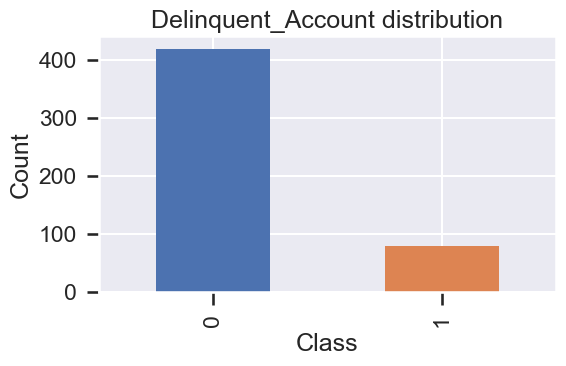

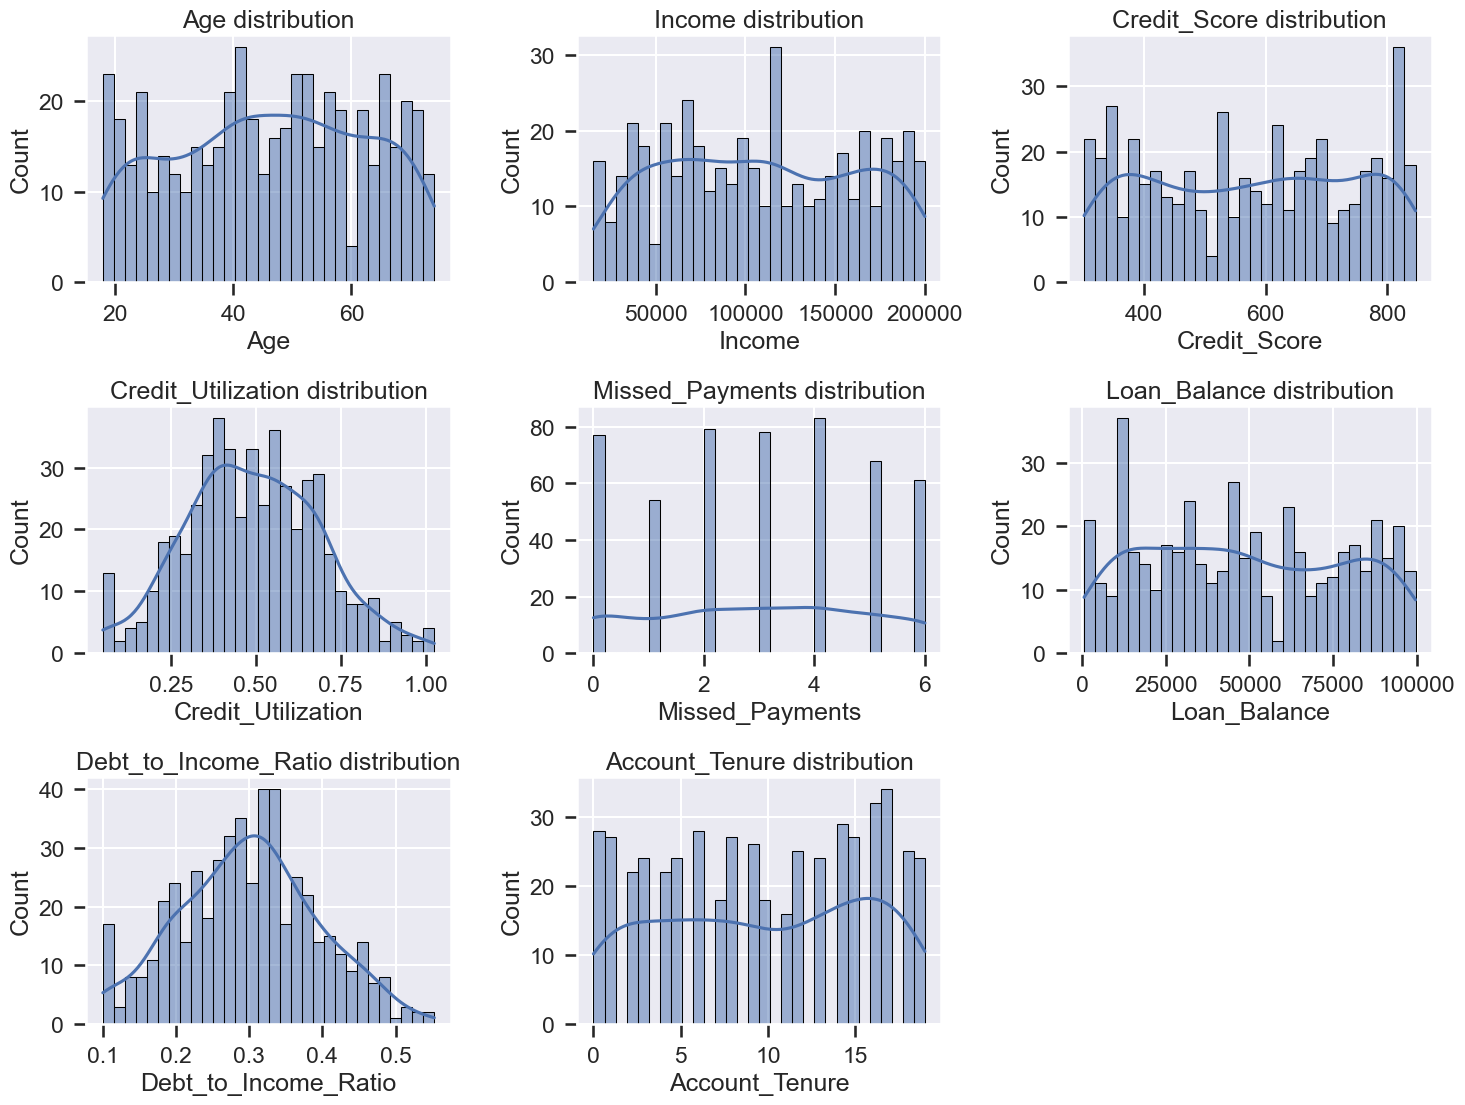

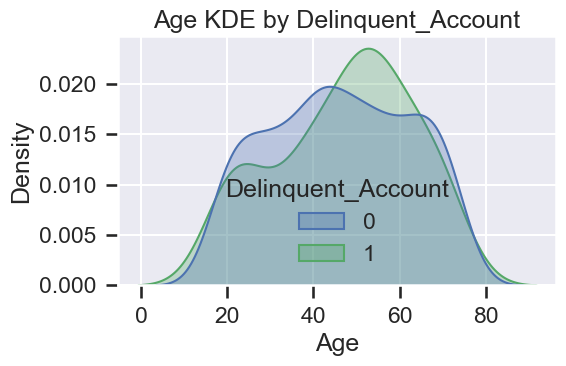

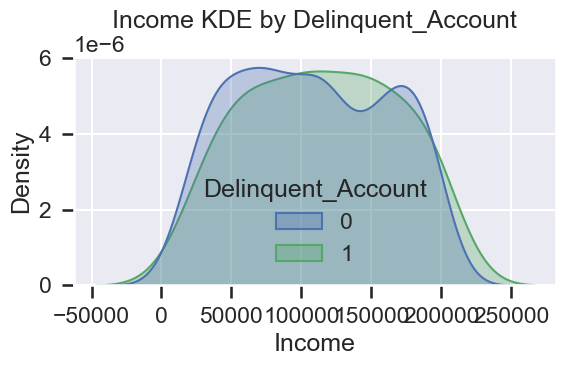

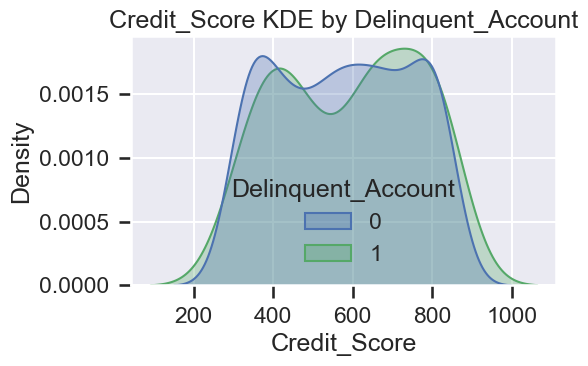

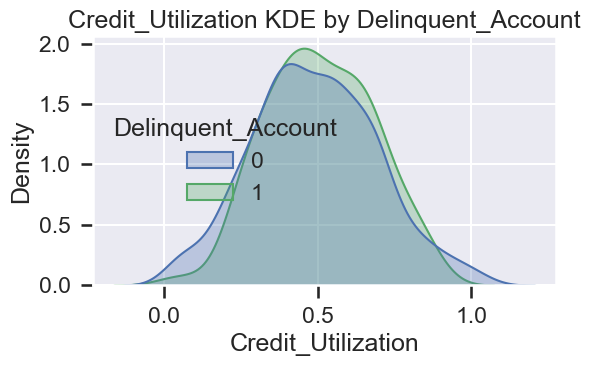

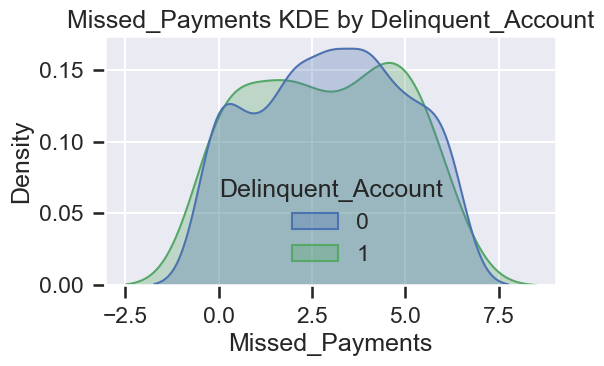

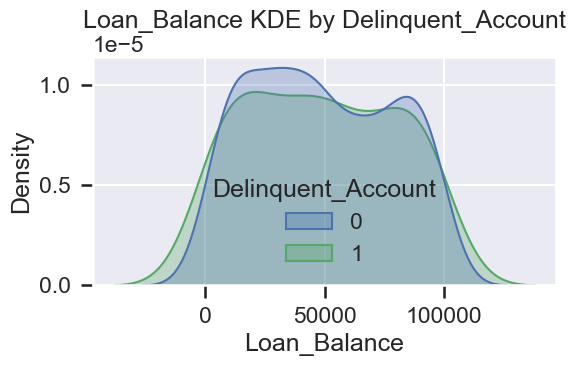

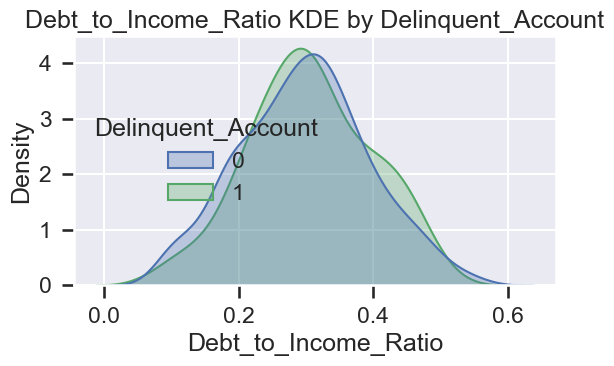

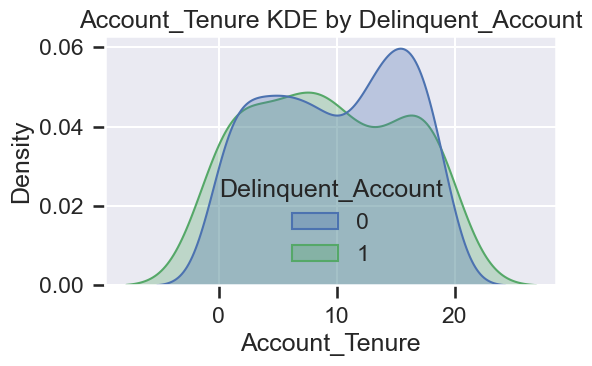

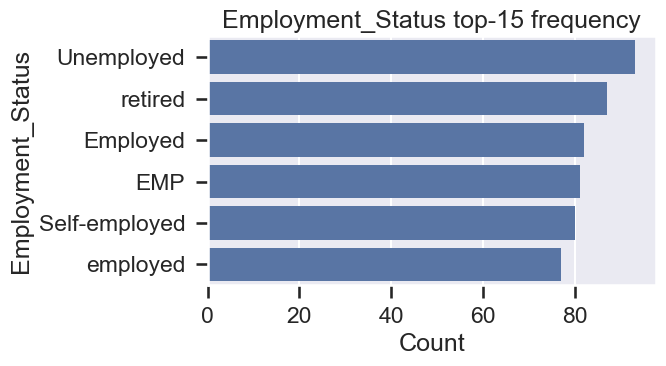

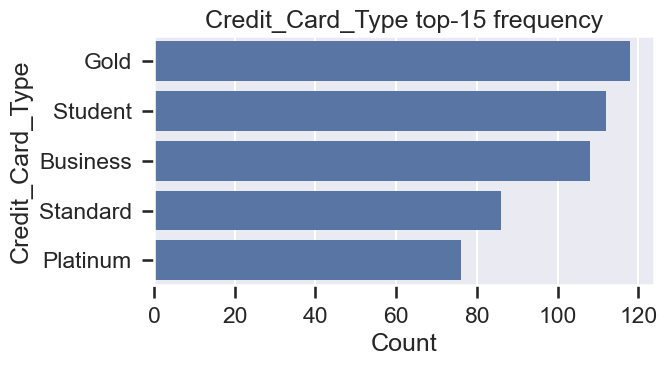

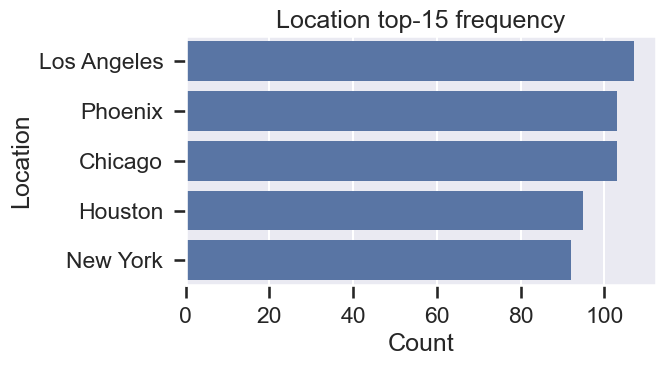

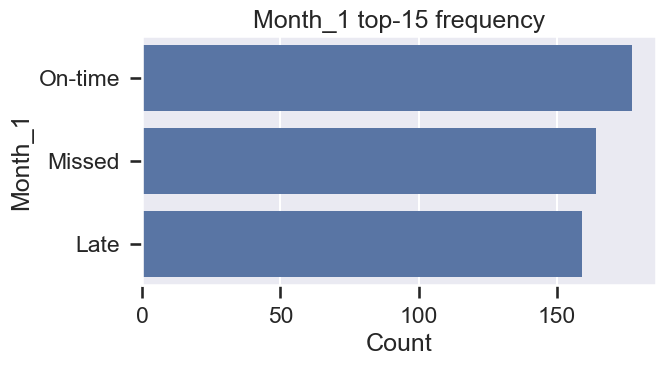

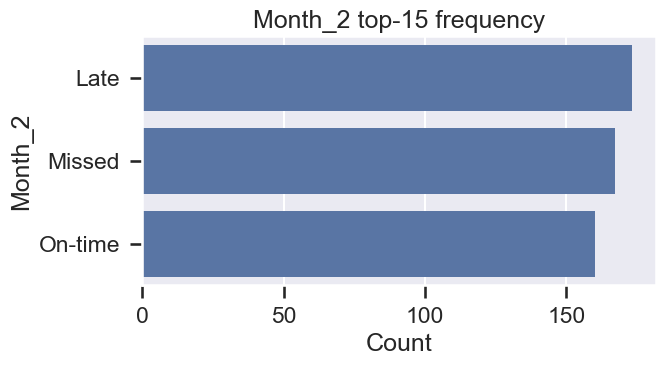

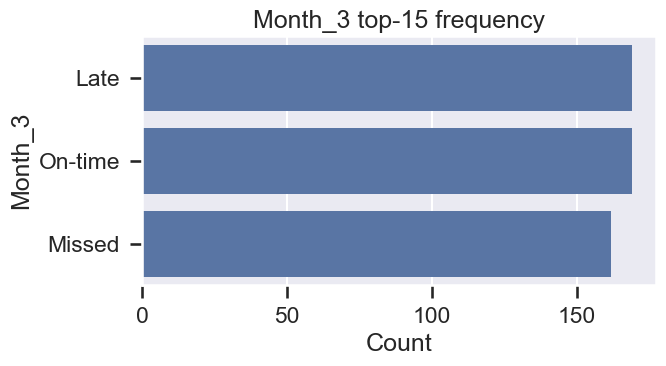

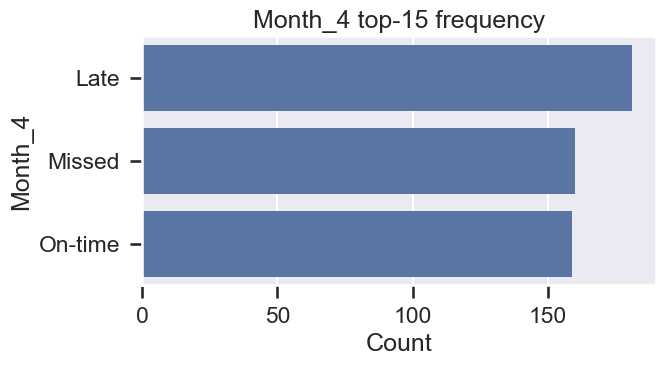

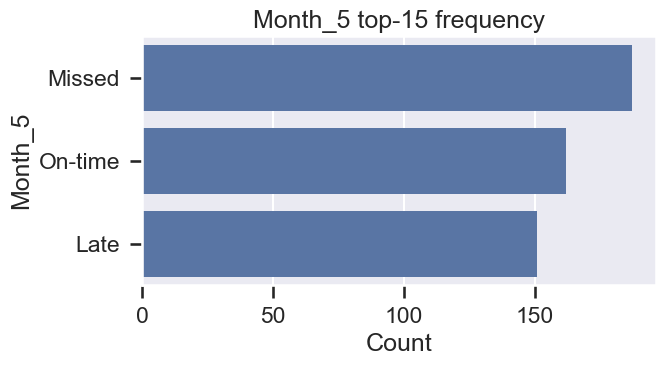

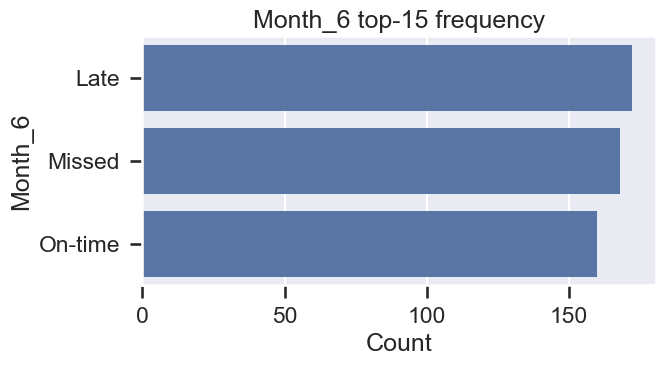

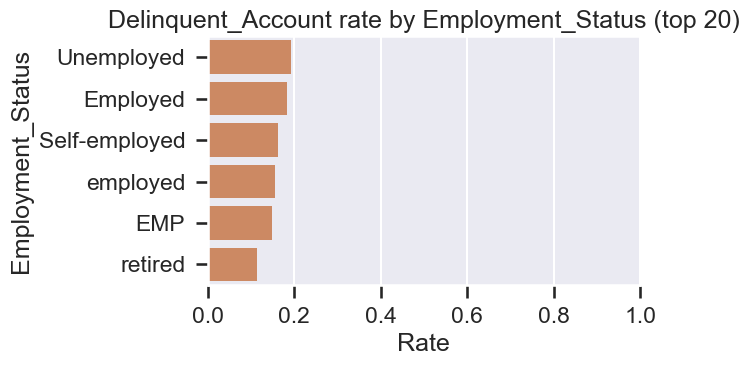

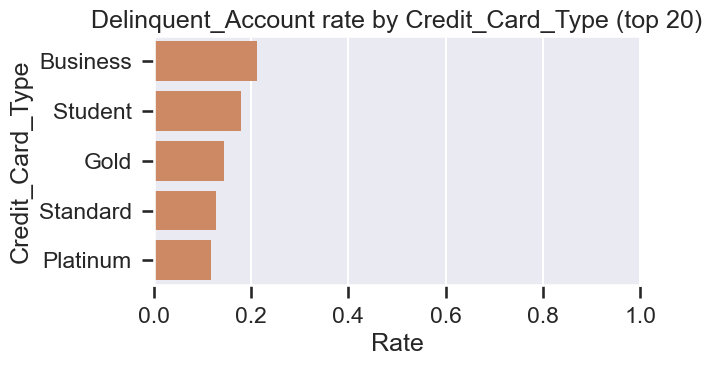

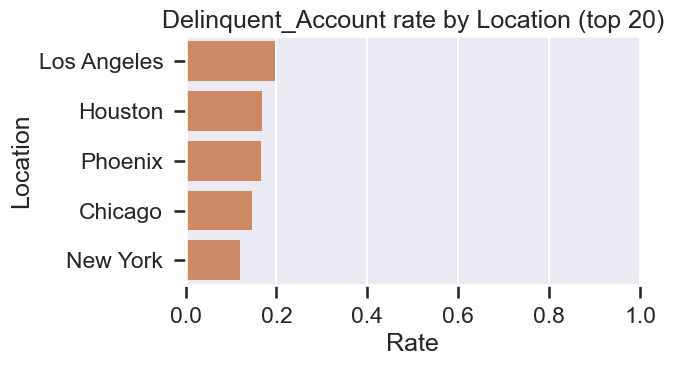

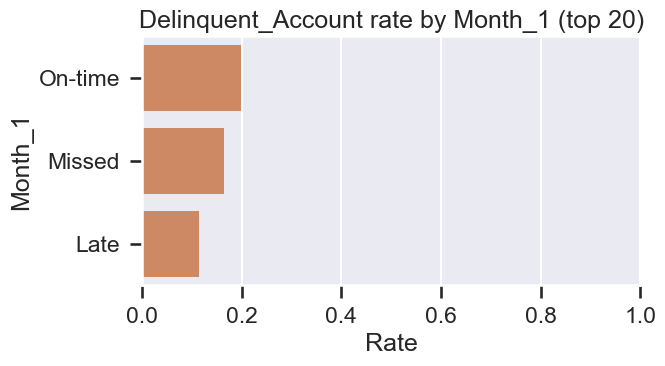

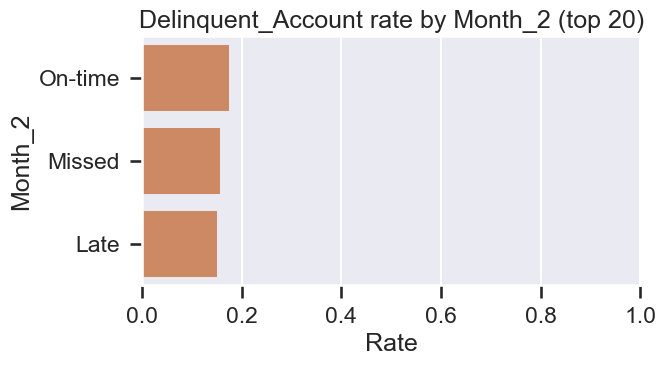

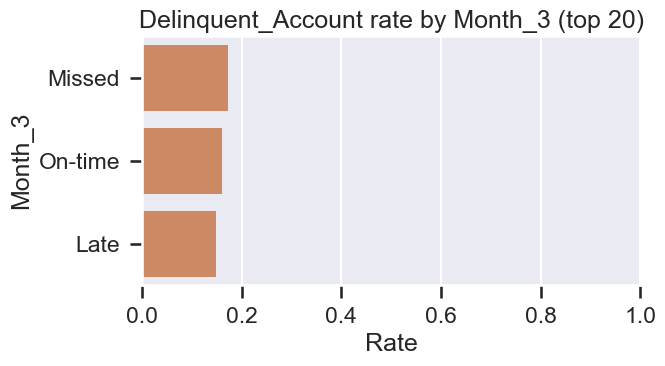

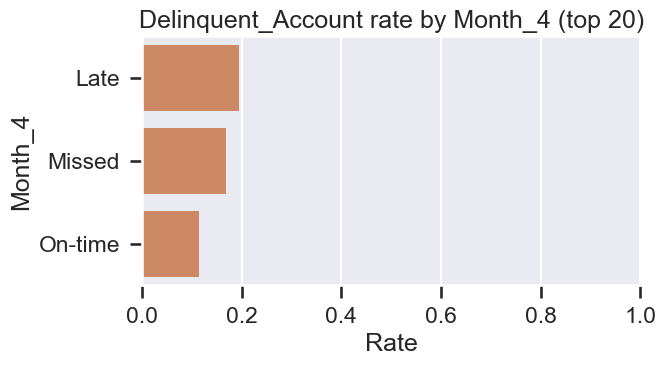

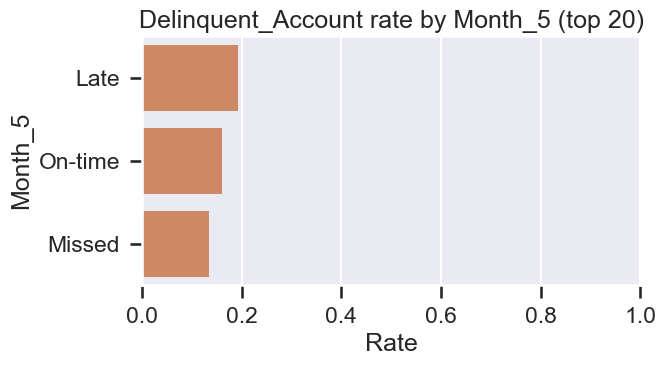

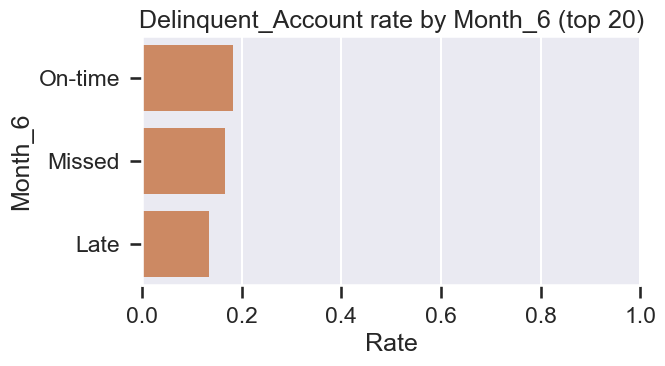

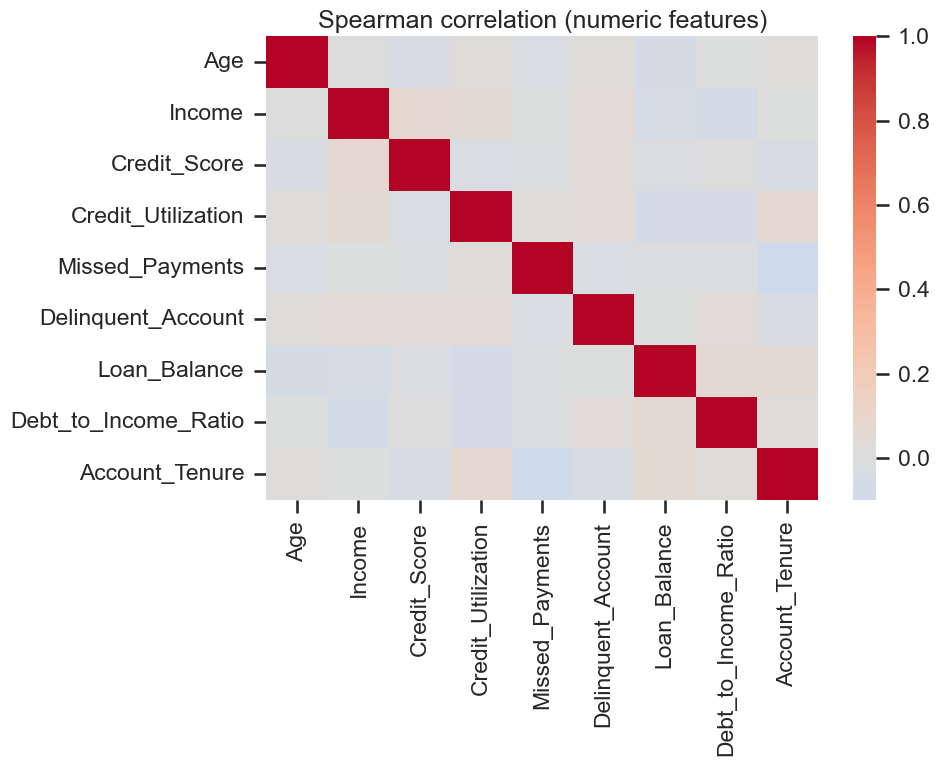

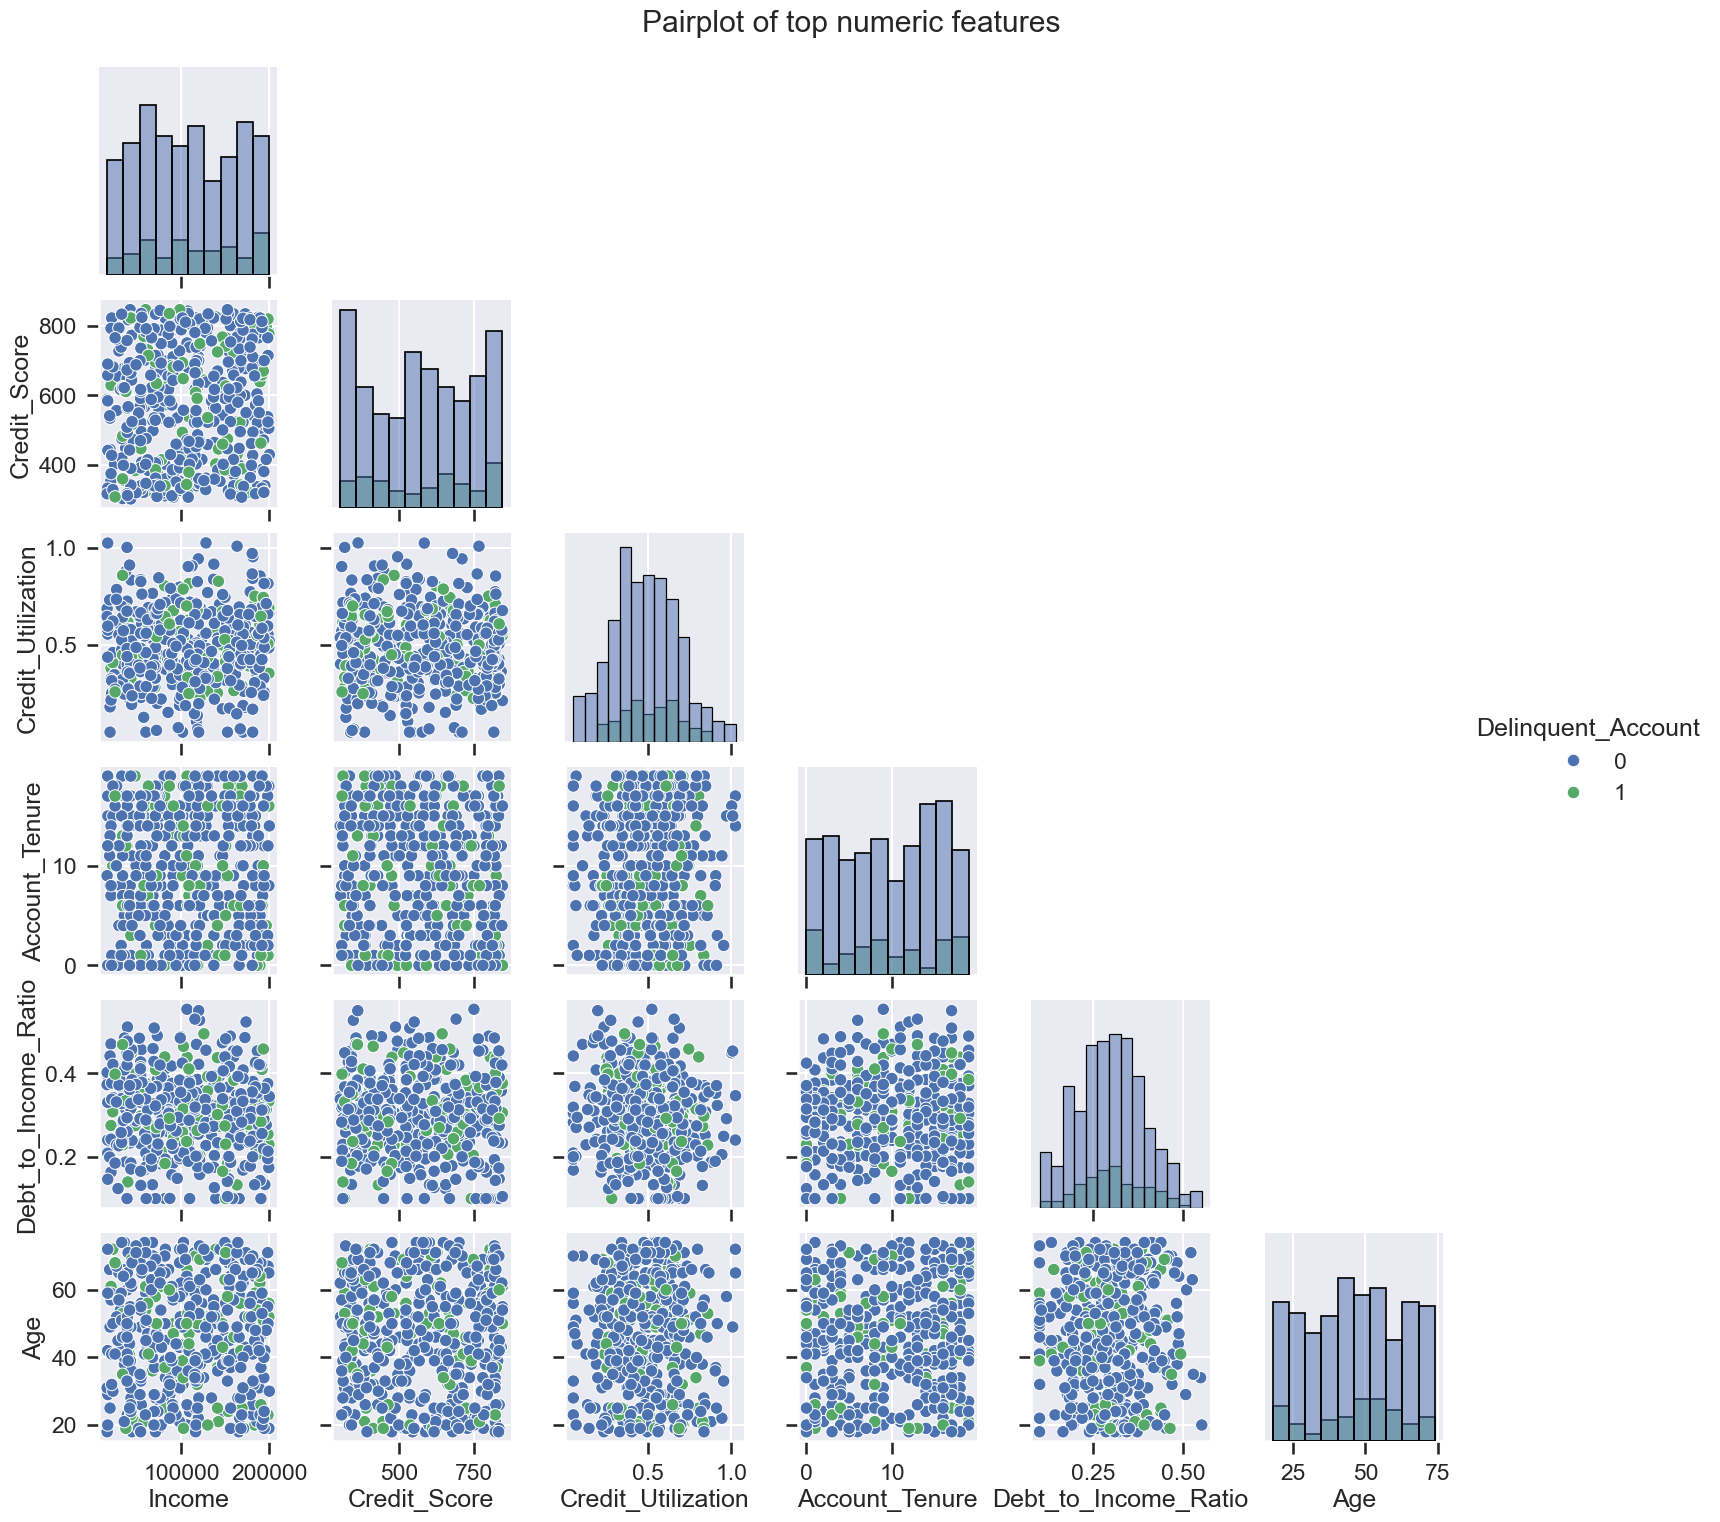

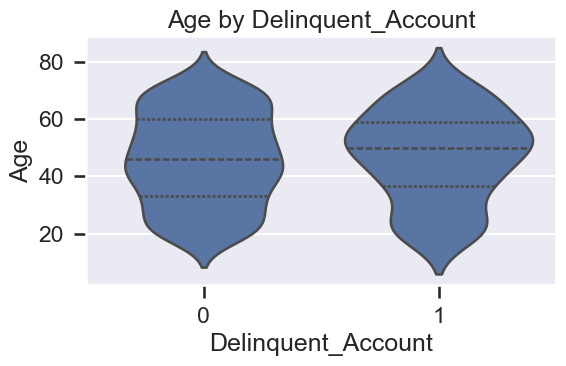

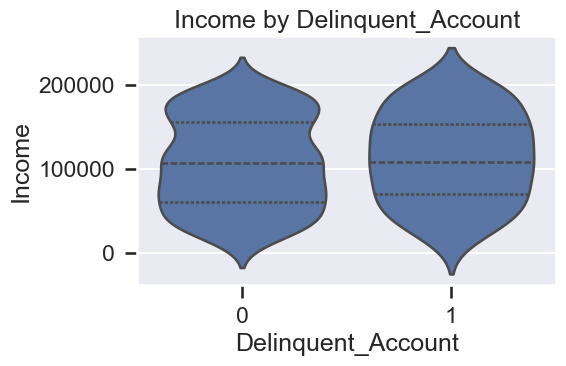

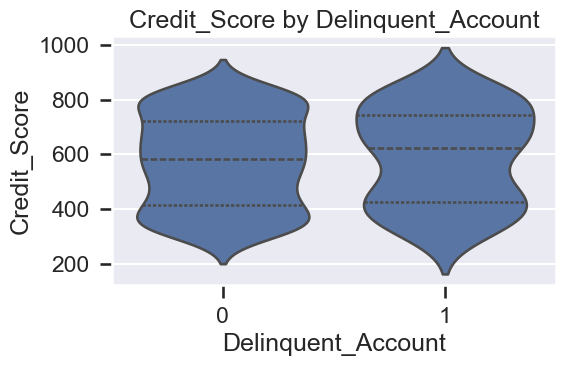

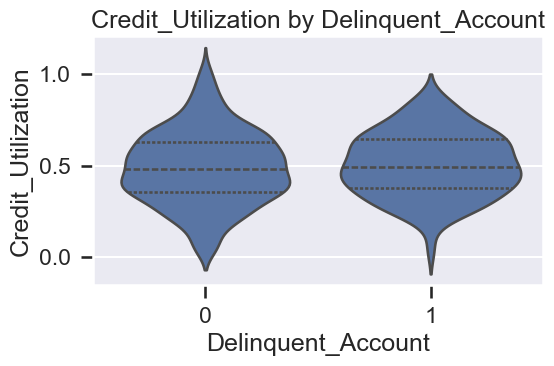

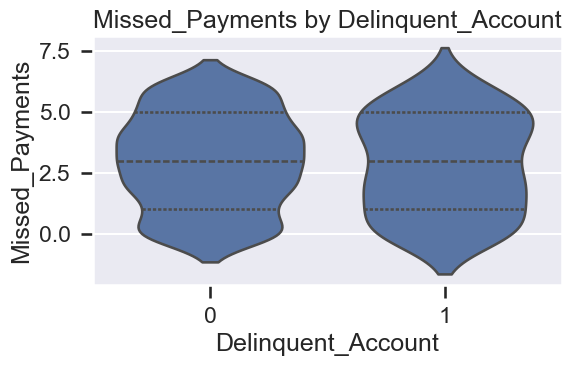

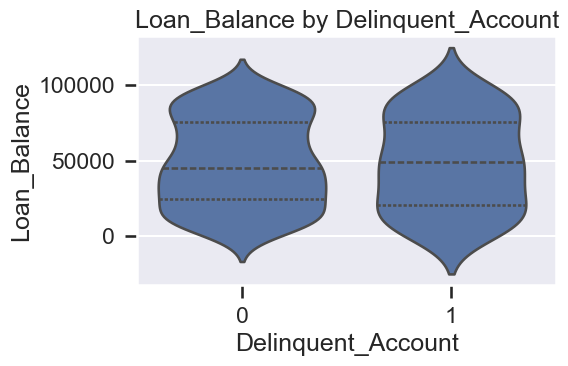

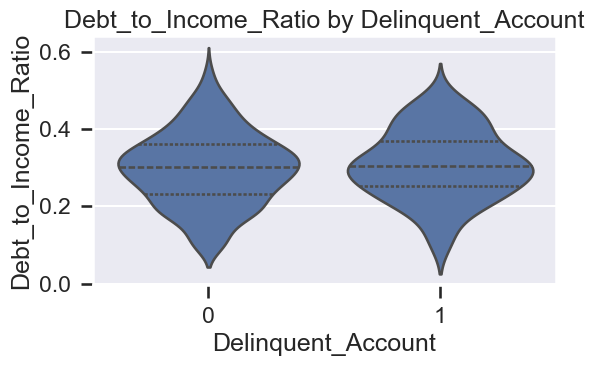

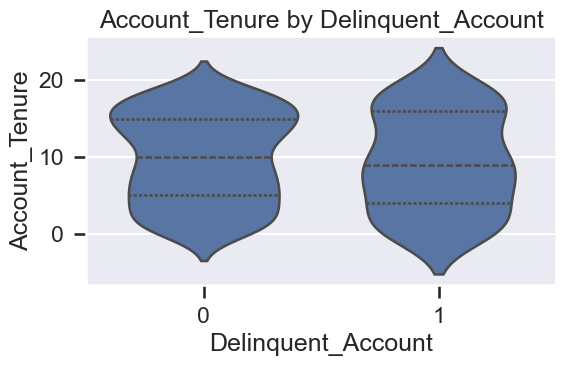

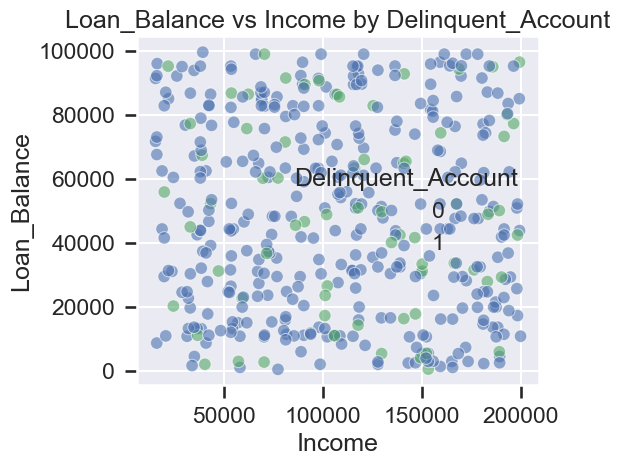

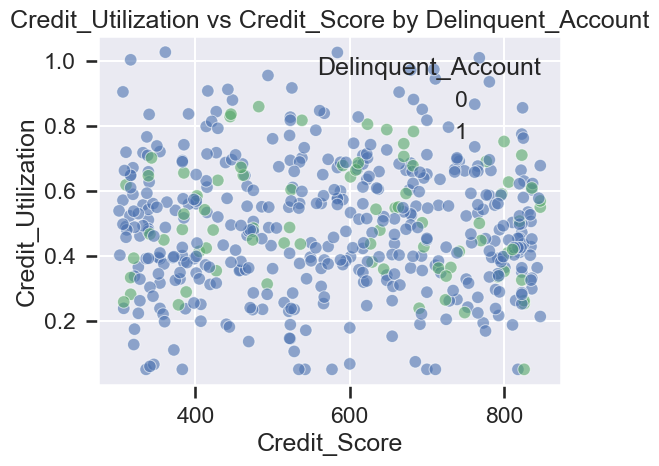

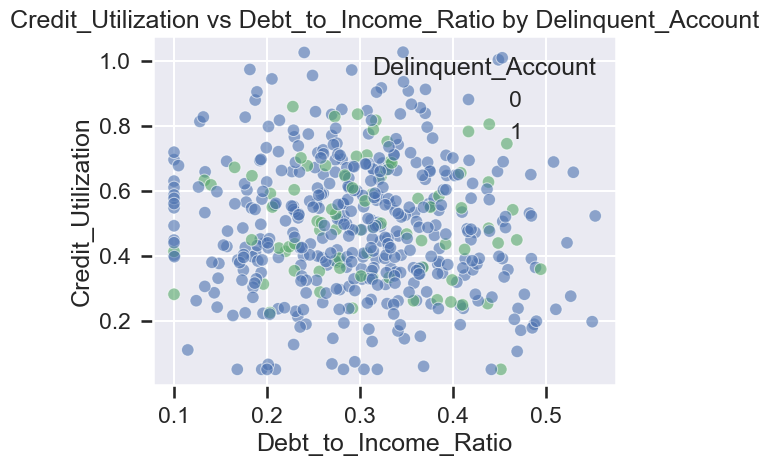

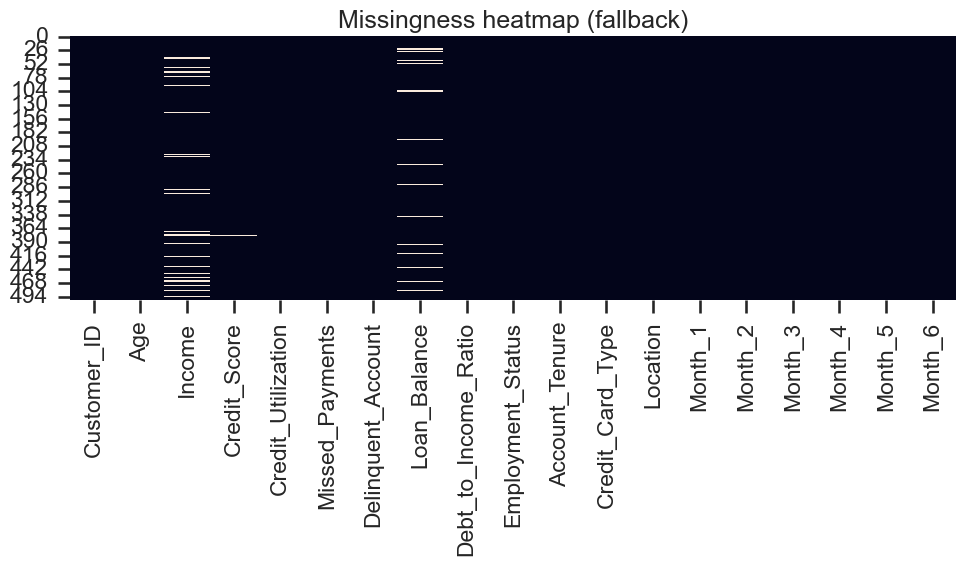

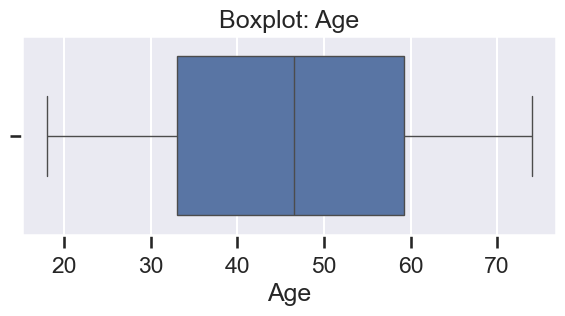

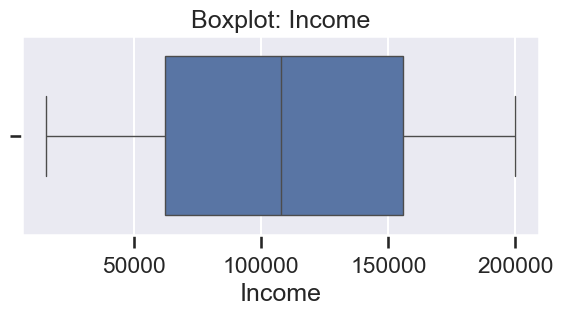

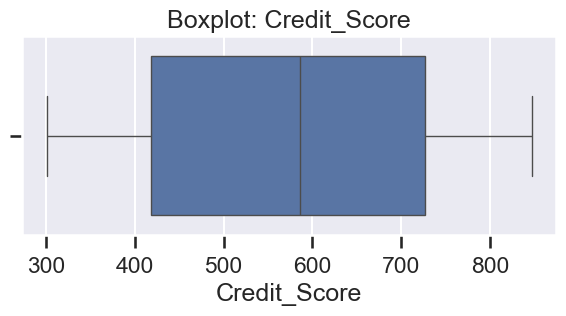

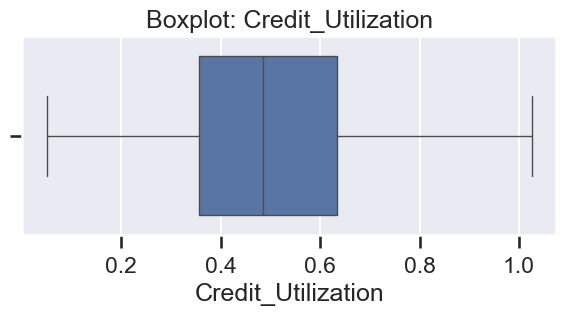

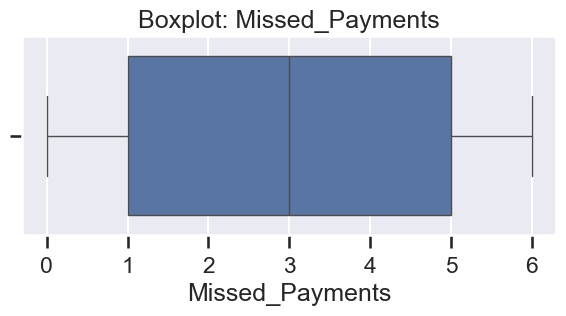

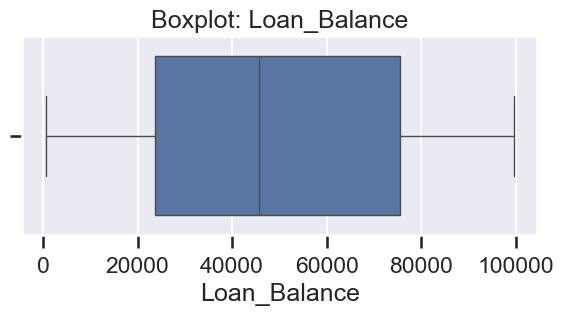

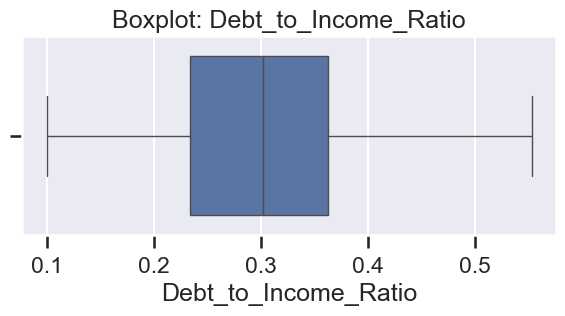

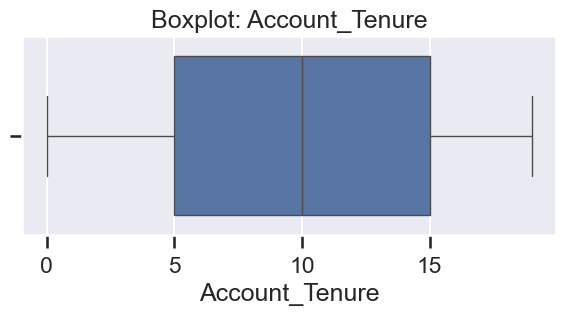

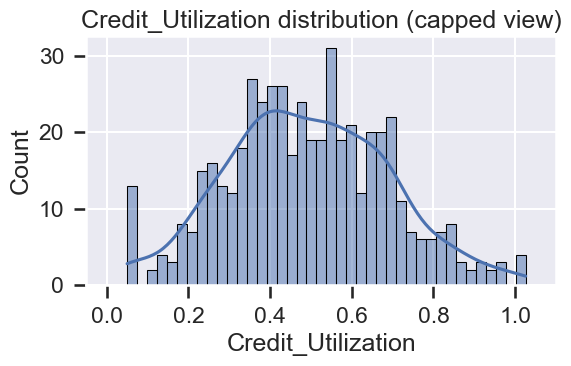

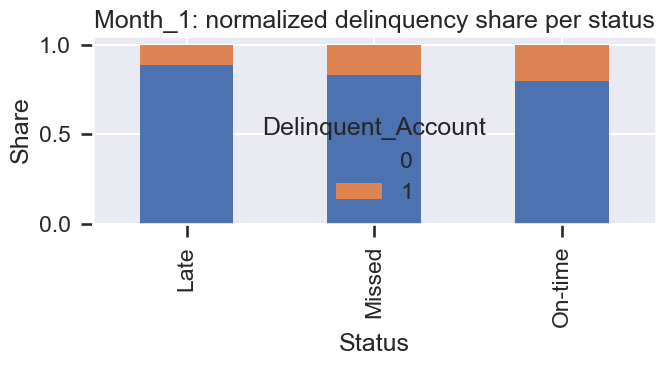

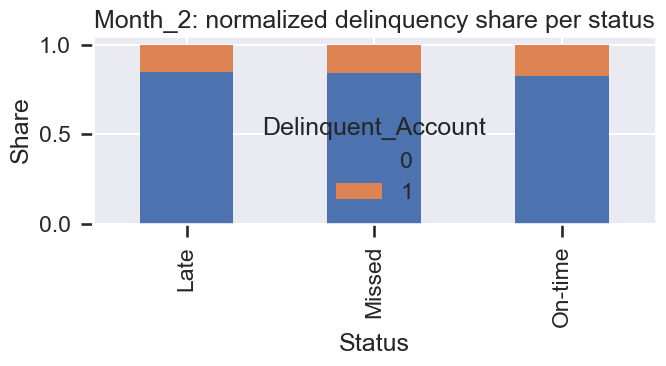

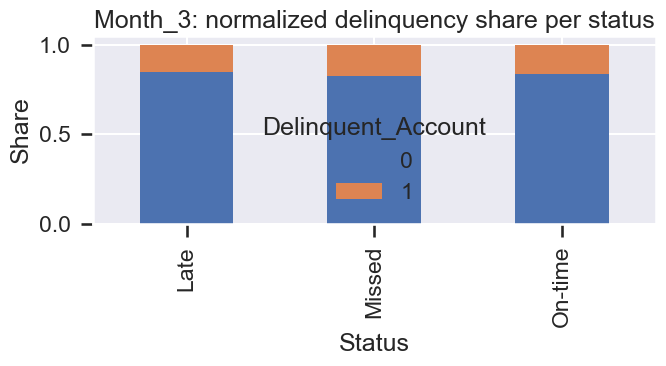

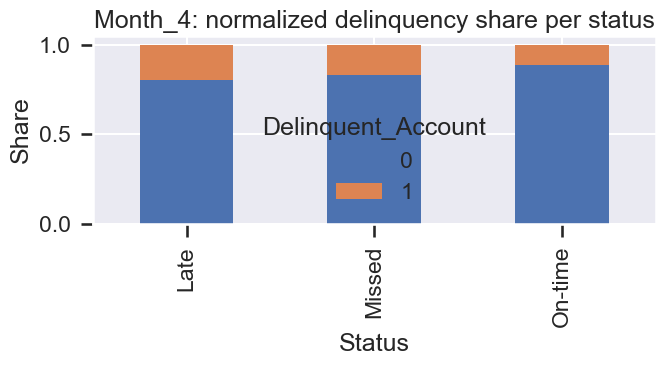

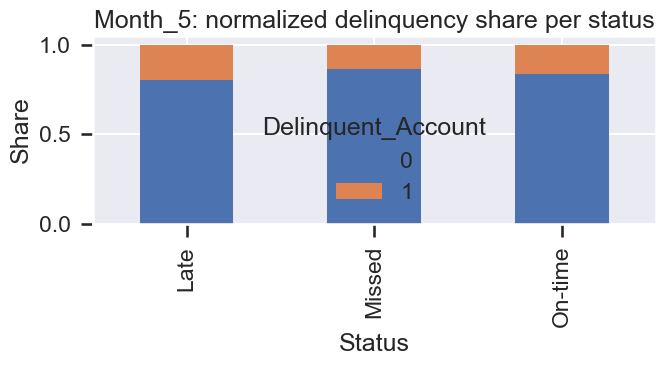

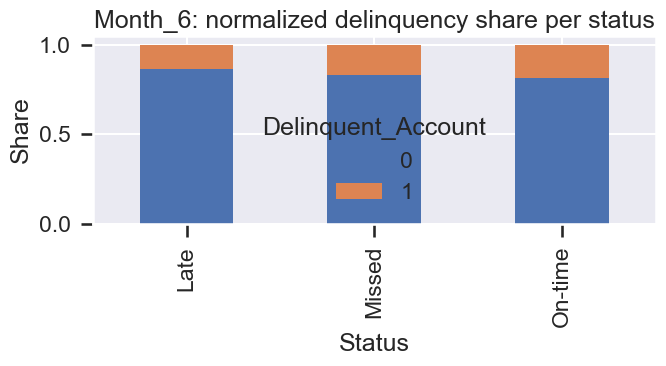

Saved figures to ./figures


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    import missingno as msno # type: ignore
except ImportError:
    msno = None

# Show plots inline when running the notebook
if 'get_ipython' in globals():
    get_ipython() # type: ignore
    %matplotlib inline

plt.style.use('seaborn-v0_8')
sns.set_context('talk')

# 0) Load data
FILE = 'Delinquency_prediction_dataset_1.xlsx'
SHEET = 'Delinquency_prediction_dataset'
df = pd.read_excel(FILE, sheet_name=SHEET)

# 1) Column groups
target = 'Delinquent_Account'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
month_cols = [c for c in df.columns if c.startswith('Month_')]
cat_cols = [c for c in df.columns if c not in numeric_cols]
id_cols = ['Customer_ID'] if 'Customer_ID' in df.columns else []

# Make output dir
os.makedirs('figures', exist_ok=True)

# 2) Overview — class balance
fig, ax = plt.subplots(figsize=(6,4))
df[target].value_counts().sort_index().plot(kind='bar', ax=ax, color=['#4c72b0','#dd8452'])
ax.set_title('Delinquent_Account distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
fig.tight_layout()
fig.savefig('figures/target_class_balance.png', dpi=150)
plt.show()

# 3) Numeric distributions (hist + KDE)
nnums = [c for c in numeric_cols if c != target]
ncols = 3
nrows = int(np.ceil(len(nnums)/ncols)) if nnums else 0
if nrows > 0:
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])
    for i, col in enumerate(nnums):
        ax = axes[i]
        sns.histplot(data=df, x=col, kde=True, ax=ax, bins=30, color='#4c72b0')
        ax.set_title(f'{col} distribution')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    fig.tight_layout()
    fig.savefig('figures/numeric_hist_kde.png', dpi=150)
    plt.show()

# 4) Numeric distributions by target (hue)
for col in nnums:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue=target, common_norm=False, fill=True, alpha=0.3, ax=ax)
    ax.set_title(f'{col} KDE by {target}')
    fig.tight_layout()
    fig.savefig(f'figures/kde_by_target_{col}.png', dpi=150)
    plt.show()

# 5) Categorical distributions (top categories)
for col in [c for c in cat_cols if c not in id_cols]:
    fig, ax = plt.subplots(figsize=(7,4))
    vc = df[col].astype(str).value_counts().head(15)
    sns.barplot(x=vc.values, y=vc.index, ax=ax, color='#4c72b0')
    ax.set_title(f'{col} top-15 frequency')
    ax.set_xlabel('Count')
    ax.set_ylabel(col)
    fig.tight_layout()
    fig.savefig(f'figures/cat_top_counts_{col}.png', dpi=150)
    plt.show()

# 6) Delinquency rate by category
for col in [c for c in cat_cols if c not in id_cols]:
    fig, ax = plt.subplots(figsize=(7,4))
    rates = df.groupby(col)[target].mean().sort_values(ascending=False).head(20)
    sns.barplot(x=rates.values, y=rates.index, ax=ax, color='#dd8452')
    ax.set_title(f'{target} rate by {col} (top 20)')
    ax.set_xlabel('Rate')
    ax.set_xlim(0, 1)
    fig.tight_layout()
    fig.savefig(f'figures/rate_by_{col}.png', dpi=150)
    plt.show()

# 7) Correlation heatmap (Spearman for robustness)
corr = df[nnumeric := [c for c in numeric_cols]].corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, ax=ax)
ax.set_title('Spearman correlation (numeric features)')
fig.tight_layout()
fig.savefig('figures/spearman_corr_heatmap.png', dpi=150)
plt.show()

# 8) Pairplot on selected numeric subset (most correlated with target)
if target in numeric_cols:
    corr_to_y = corr[target].drop(index=target).abs().sort_values(ascending=False)
    top_feats = corr_to_y.head(6).index.tolist()
    import itertools
    pp_cols = list(dict.fromkeys(top_feats + ['Credit_Utilization','Credit_Score','Income']))[:6]
    sns.pairplot(df[pp_cols + [target]].dropna(), hue=target, corner=True, diag_kind='hist')
    plt.suptitle('Pairplot of top numeric features', y=1.02)
    plt.savefig('figures/pairplot_top_numeric.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close('all')

# 9) Box/Violin plots by target
for col in nnums:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.violinplot(data=df, x=target, y=col, inner='quartile', ax=ax)
    ax.set_title(f'{col} by {target}')
    fig.tight_layout()
    fig.savefig(f'figures/violin_{col}_by_target.png', dpi=150)
    plt.show()

# 10) Scatter relationships colored by target
pairs = [
    ('Income', 'Loan_Balance'),
    ('Credit_Score', 'Credit_Utilization'),
    ('Debt_to_Income_Ratio', 'Credit_Utilization'),
]
for x, y in pairs:
    if x in df.columns and y in df.columns:
        fig, ax = plt.subplots(figsize=(6,5))
        sns.scatterplot(data=df, x=x, y=y, hue=target, alpha=0.6, ax=ax)
        ax.set_title(f'{y} vs {x} by {target}')
        fig.tight_layout()
        fig.savefig(f'figures/scatter_{y}_vs_{x}.png', dpi=150)
        plt.show()

# 11) Missingness visualization
if msno is not None:
    fig = msno.matrix(df, figsize=(10,5))
    plt.title('Missingness matrix')
    plt.savefig('figures/missingness_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    fig = msno.heatmap(df, figsize=(8,6))
    plt.title('Missingness heatmap')
    plt.savefig('figures/missingness_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close('all')
else:
    # Fallback: simple heatmap
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(df.isna(), cbar=False, ax=ax)
    ax.set_title('Missingness heatmap (fallback)')
    fig.tight_layout()
    fig.savefig('figures/missingness_heatmap_fallback.png', dpi=150)
    plt.show()

# 12) Outlier views
for col in nnums:
    fig, ax = plt.subplots(figsize=(6,3.5))
    sns.boxplot(data=df, x=col, ax=ax, color='#4c72b0')
    ax.set_title(f'Boxplot: {col}')
    fig.tight_layout()
    fig.savefig(f'figures/box_{col}.png', dpi=150)
    plt.show()

# 13) Credit_Utilization focused views
if 'Credit_Utilization' in df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df['Credit_Utilization'], bins=40, kde=True, ax=ax, color='#4c72b0')
    ax.set_xlim(-0.05, 1.1)
    ax.set_title('Credit_Utilization distribution (capped view)')
    fig.tight_layout()
    fig.savefig('figures/credit_utilization_hist.png', dpi=150)
    plt.show()

    # Proportion > 1
    pct_gt1 = (df['Credit_Utilization'] > 1).mean()*100
    with open('figures/credit_utilization_notes.txt', 'w') as f:
        f.write(f'Pct Credit_Utilization > 1: {pct_gt1:.2f}%\\n')

# 14) Monthly repayment behavior: stacked bars of status vs target
for m in month_cols:
    ctab = pd.crosstab(df[m], df[target], normalize='index')
    fig, ax = plt.subplots(figsize=(7,4))
    ctab.plot(kind='bar', stacked=True, ax=ax, color=['#4c72b0','#dd8452'])
    ax.set_title(f'{m}: normalized delinquency share per status')
    ax.set_xlabel('Status')
    ax.set_ylabel('Share')
    ax.legend(title=target, loc='best')
    fig.tight_layout()
    fig.savefig(f'figures/{m}_stacked_target_share.png', dpi=150)
    plt.show()

print('Saved figures to ./figures')
